In [2]:
import pandas_datareader.data as pdr
from datetime import datetime

"""
### Get bitcoin data
"""
end = datetime.today()
start = datetime(end.year-4,end.month,end.day)
df = pdr.DataReader('BTC-USD','yahoo',start, end)

df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-06-12,716.004028,664.487000,671.653992,704.375977,243295008.0,704.375977
2016-06-13,704.504028,662.804016,704.504028,685.559021,186694000.0,685.559021
2016-06-14,696.302979,672.560974,685.684998,694.468994,99223800.0,694.468994
2016-06-15,773.721985,696.523010,696.523010,766.307983,271633984.0,766.307983
2016-06-16,775.356018,716.556030,768.487000,748.908997,363320992.0,748.908997


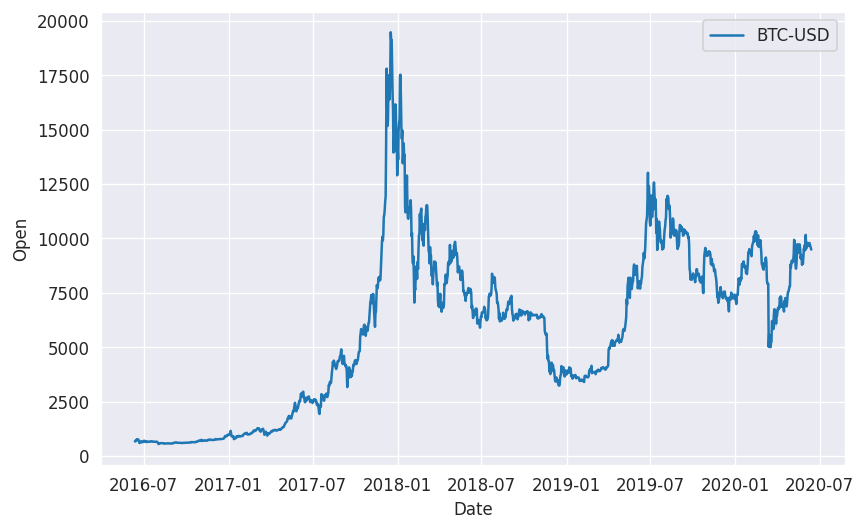

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.figure(figsize=(8,5),dpi=120)
sns.lineplot(df.index,df.Open,label='BTC-USD');

In [4]:
"""
### Clean data by scaling each feature down to (0, 1)
"""
def normalize_cols(df,cols):
    """Scale the values of each feature
    according to the columns max value"""
    data = df.loc[:,cols]
    for col in cols:
        scaler = lambda x: x / data[col].max()
        data[col] = data[col].apply(scaler)
    print(data[cols].head())
    return data[cols].values

features = df.columns.values[:-1] # columns to train model on
X = normalize_cols(df,features)

                High       Low      Open     Close    Volume
Date                                                        
2016-06-12  0.035642  0.035021  0.034487  0.036127  0.003281
2016-06-13  0.035069  0.034932  0.036173  0.035162  0.002518
2016-06-14  0.034661  0.035446  0.035207  0.035619  0.001338
2016-06-15  0.038515  0.036709  0.035764  0.039303  0.003663
2016-06-16  0.038596  0.037765  0.039459  0.038411  0.004899


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

"""
### Turn each signal into a labeled dataset
"""

def window_dataset(series, window_size, batch_size, shuffle_buffer):
    """Funtion to turn time series data into set of sequences 
    where the last value is the intended output of our model"""
    ser = tf.expand_dims(series, axis=-1)
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window_size + 1, shift=1, drop_remainder=True)
    data = data.flat_map(lambda w: w.batch(window_size + 1))
    data = data.shuffle(shuffle_buffer)
    data = data.map(lambda w: (w[:-1], w[1:]))
    return data.batch(batch_size).prefetch(1)


window_size = 30   # num. days per training instance
batch_size = 128   # num. of training instances per epoch
buffer_size = 1000 # num of samples in memory for random selection
split_time = 1400  # where to split the for training/validation

x_train = X[:split_time,:]
x_test = X[split_time:,:]

print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_test.shape}")

train_set = window_dataset(x_train,window_size,batch_size,buffer_size)

Training data shape: (1400, 5)
Validation data shape: (60, 5)


In [24]:
keras.backend.clear_session()

"""
### Choose and connect the model components   
"""

# 1D convolution layers
conv1 = layers.Conv1D(
    filters=64,kernel_size=15,strides=1,
    padding="causal",activation="relu",
    input_shape=[None,len(features)])

conv2 = layers.Conv1D(
    filters=32,kernel_size=5,strides=1,
    padding="causal",activation="tanh")

# Bidirectional LSTM layers
lstm1 = layers.Bidirectional(layers.LSTM(30,return_sequences=True))
lstm2 = layers.Bidirectional(layers.LSTM(20,return_sequences=True))

# Model construction
inputs = layers.Input(shape=[None,len(features)])
x = conv1(inputs)
x = lstm1(x)
x = lstm2(x)
x = conv2(x)
x = layers.Dense(64,activation='relu')(x)
x = layers.Dropout(.1)(x)
x = layers.Dense(1,activation='tanh')(x)
outputs = layers.Lambda(lambda x: 25*abs(x))(x)

# SGD optimizer and Huber loss
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
loss = keras.losses.Huber()


model = keras.Model(inputs=inputs,outputs=outputs)
model.compile(optimizer,loss,
              metrics=["mae"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 5)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          4864      
_________________________________________________________________
bidirectional (Bidirectional (None, None, 60)          22800     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 40)          12960     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          6432      
_________________________________________________________________
dense (Dense)                (None, None, 64)          2112      
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0     

In [25]:
"""
### Train model
"""
epochs = 50

history = model.fit(train_set, epochs=epochs, verbose=0)
print(f"Model trained for {epochs} epochs")

Model trained for 50 epochs


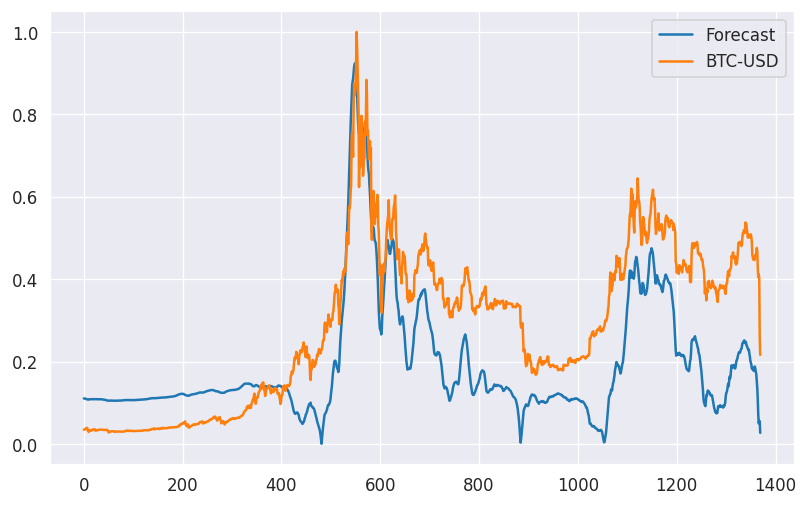

In [26]:
"""
### Inspect training results
"""

def model_forecast(model, X, window_size):
    """Takes in numpy array, creates a windowed tensor 
    and predicts the following value on each window"""
    data = tf.data.Dataset.from_tensor_slices(X)
    data = data.window(window_size, shift=1, drop_remainder=True)
    data = data.flat_map(lambda w: w.batch(window_size))
    data = data.batch(32).prefetch(1)
    forecast = model.predict(data)
    return forecast

train_window = [i for i in range(split_time-window_size)]

forecast = model_forecast(model,x_train,window_size)

plt.figure(figsize=(8,5),dpi=120)
sns.lineplot(train_window,forecast[:-1,1,0],label='Forecast')
sns.lineplot(train_window,X[:split_time-window_size,1],label='BTC-USD')
plt.show()

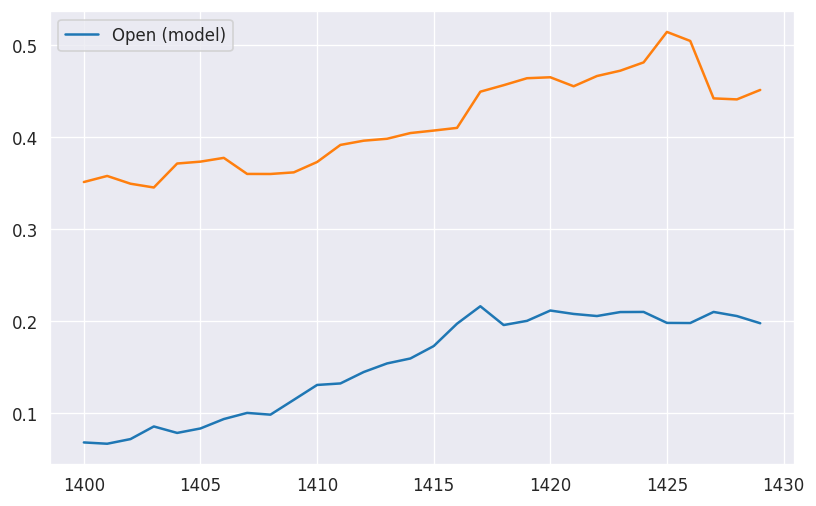

In [27]:
"""
### Make predictions on unseen data
"""

val_window = [i for i in range(split_time,len(df)-window_size)]

forecast = model_forecast(model,x_test,window_size)

plt.figure(figsize=(8,5),dpi=120)
sns.lineplot(val_window,forecast[:-1,1,0],label='Forecast')
sns.lineplot(val_window,X[split_time:-window_size,1],label='BTC-USD')
plt.show()